<Axes: title={'center': 'nan -> local 3×3 fill'}>

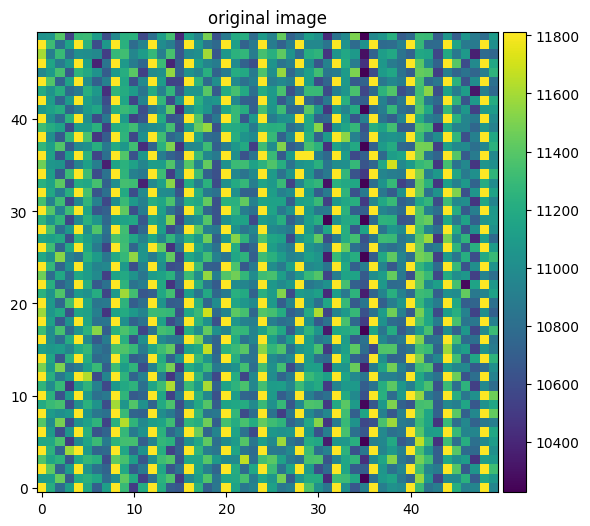

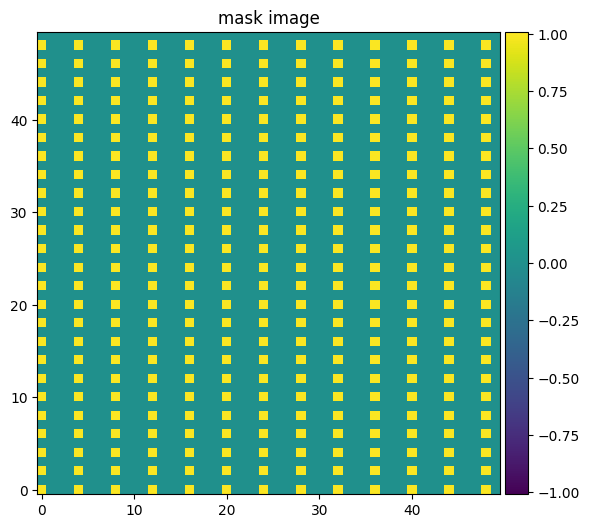

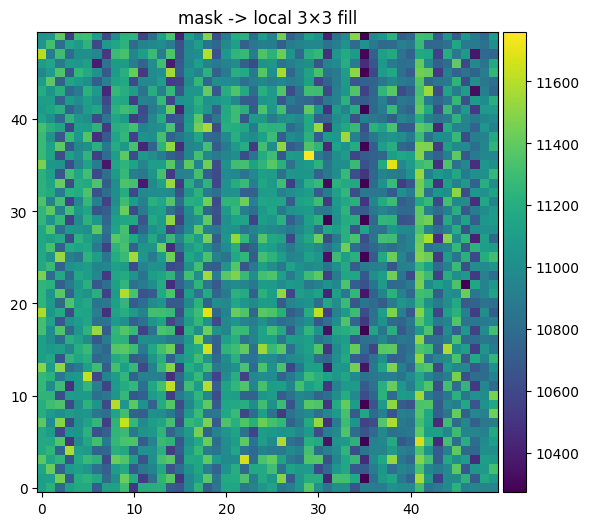

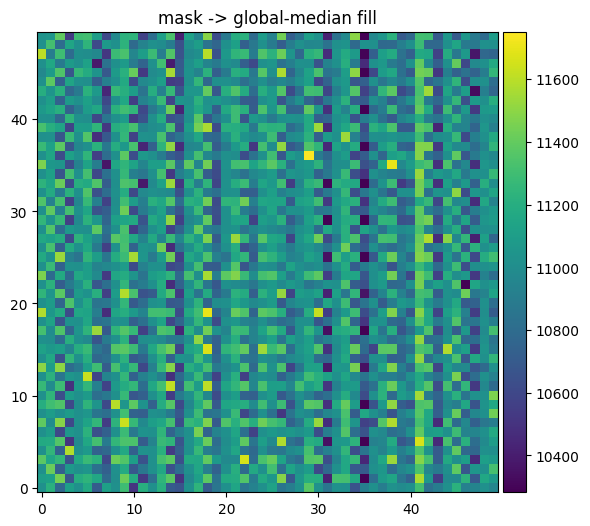

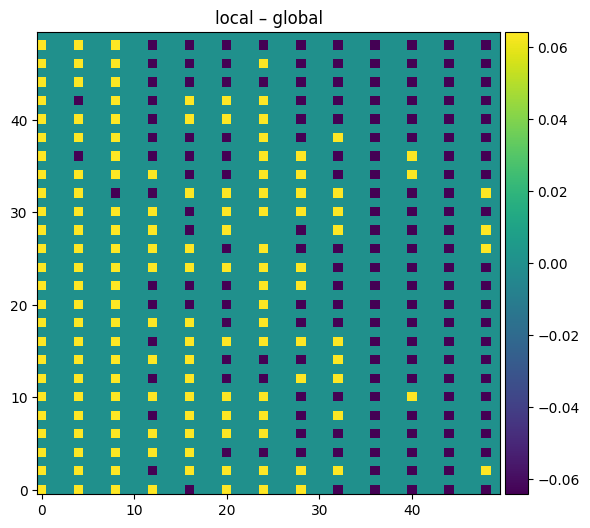

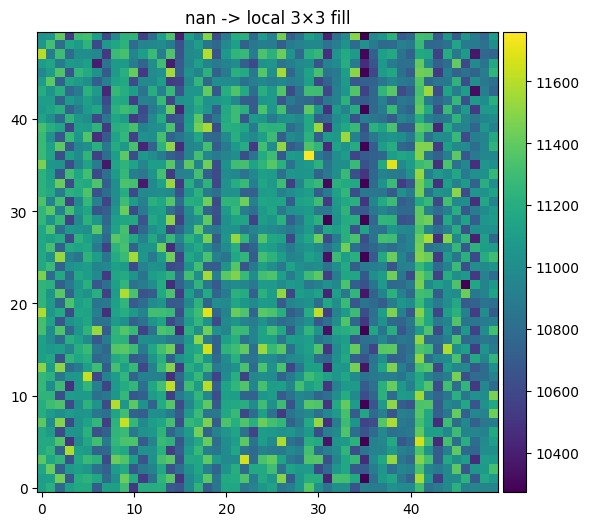

In [18]:
import os
from glob import glob
from imagedaemon import registry
import numpy as np
# let's try to run the winter calibration pipeline
from imagedaemon.utils.paths import RAW_DATA_DIR
from imagedaemon.utils.image import Image
from imagedaemon.utils.wcs_utils import pix2sky
from imagedaemon.cameras.winter.winter_image import WinterImage
from imagedaemon.utils.image import plot_image


from scipy.ndimage import generic_filter

def _nanmedian(vec: np.ndarray) -> float:
    """Helper for generic_filter – median of finite values in *vec*."""
    vec = vec[np.isfinite(vec)]
    return np.nanmedian(vec) if vec.size else np.nan

def replace_masked_with_local_median(data: np.ndarray,
                                     mask: np.ndarray,
                                     halfwin: int = 1) -> np.ndarray:
    """
    Replace every True‑pixel in *mask* by the nan‑median of its (2*halfwin+1)²
    neighbours in *data*.

    Parameters
    ----------
    data   : 2‑D NumPy array (your image)
    mask   : same shape, True where you want to fill
    halfwin: size of the square neighbourhood (1 ⇒ 3×3, 2 ⇒ 5×5, …)

    Returns
    -------
    A *copy* of *data* with the masked pixels replaced.
    """
    if data.shape != mask.shape:
        raise ValueError("data and mask must have identical shape")

    # work on a copy; we’ll write the replacements only where mask==True
    filled = data.copy().astype(float)
    filled[mask] = np.nan                 # mark masked pixels as NaN

    # build the footprint for generic_filter (square of ones)
    size = 2 * halfwin + 1
    footprint = np.ones((size, size), dtype=bool)

    # run nan‑median filter everywhere
    # mode='nearest' pads the borders, cval=np.nan fills outside with NaN
    filtered = generic_filter(
        filled,
        function=_nanmedian,
        footprint=footprint,
        mode="nearest",
        cval=np.nan,
    )

    # copy the filtered values *only* onto the originally masked pixels
    filled[mask] = filtered[mask]
    return filled

def replace_nans_with_local_median(data: np.ndarray,
                                   halfwin: int = 1) -> np.ndarray:
    """
    Replace every NaN/inf in *data* by the median of its local window.

    Parameters
    ----------
    data
        2‑D NumPy array (image) – **will not be modified in‑place**.
    halfwin
        Window “radius”;  
        1 ⇒ 3×3 neighbourhood, 2 ⇒ 5×5, …

    Returns
    -------
    A *copy* of *data* with all non‑finite pixels filled.
    """
    if data.ndim != 2:
        raise ValueError("Input must be a 2‑D array")

    filled = data.copy().astype(float)        # work on a copy

    # build a square footprint for the filter
    size = 2 * halfwin + 1
    footprint = np.ones((size, size), dtype=bool)

    # median‑filter the whole image, skipping NaNs inside the window
    filtered = generic_filter(
        filled,
        function=_nanmedian,
        footprint=footprint,
        mode="nearest",     # replicate edge pixels
        cval=np.nan,        # area outside image treated as NaN
    )

    # write the filtered value *only* where data is non‑finite
    bad = ~np.isfinite(filled)
    filled[bad] = filtered[bad]

    return filled

winter = registry.get("winter")

science_dir = os.path.join(RAW_DATA_DIR, "winter", "science", "30s")


science_images = sorted(glob(os.path.join(science_dir, "*mef.fits")))
science_image = science_images[0]

addr = "sb"

winterimg = WinterImage(science_image)

sbimg = winterimg.get_sensor_image(addr)

roi = [100, 100, 150, 150]

data_roi        = sbimg.data[roi[0]:roi[2], roi[1]:roi[3]].astype(float)
mask_roi        = sbimg.mask[roi[0]:roi[2], roi[1]:roi[3]]

# --- plot the original image ------------------------------------------
plot_image(data_roi, title="original image")
# --- plot the mask image ---------------------------------------------
plot_image(mask_roi, title="mask image")

# --- version A : local 3×3 median -------------------------------------
loc_filled = replace_masked_with_local_median(data_roi, mask_roi, halfwin=1)

# --- version B : single global median ---------------------------------
glob_filled = data_roi.copy()
glob_filled[mask_roi] = np.nan                # mark
gmed = np.nanmedian(glob_filled)              # global value
glob_filled[mask_roi] = gmed                  # fill

# --- version C : local 3×3 median, but with NaN instead of mask --------
loc_filled_mask2nan = data_roi.copy()
loc_filled_mask2nan[mask_roi] = np.nan      # mark
loc_filled_nan2locmed = replace_nans_with_local_median(loc_filled_mask2nan, halfwin=1)

# --- difference --------------------------------------------------------
diff = loc_filled - glob_filled

plot_image(loc_filled, title="mask -> local 3×3 fill")
plot_image(glob_filled, title="mask -> global‑median fill")
plot_image(diff, title="local – global")
plot_image(loc_filled_nan2locmed, title="nan -> local 3×3 fill")